# Simpsons Character Classification with EfficientNetV2B0
Simple image classification using EfficientNetV2B0 transfer learning and fine tuning.

In [1]:
#install required libaries
%pip install tensorflow scikit-learn matplotlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np
import os

print(f"TensorFlow version: {tf.__version__}")

Note: you may need to restart the kernel to use updated packages.


2025-12-08 22:20:13.029637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dsu/code/tf/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


TensorFlow version: 2.20.0


The kernel kept crashing when we trained the model. Therefore, we set up configured the GPU memory growth and enabled mixed precision to make training much more stable.

In [2]:
#configure GPU memory growth and enable mixed precision
try:
    gpus = tf.config.list_physical_devices('GPU') #detects gpu
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #only allocates memory as needed
        tf.keras.backend.clear_session()
        mixed_precision.set_global_policy('mixed_float16') #uses fp16 where it is safe, makes training faster
        print(f"GPUs detected: {[gpu.name for gpu in gpus]}")
        print(f"Mixed precision policy: {mixed_precision.global_policy()}")
    else:
        print("No GPU detected; running on CPU.")
except RuntimeError as err:
    #memory growth must be set before GPUs are initialized
    print(f"GPU configuration warning: {err}")

GPUs detected: ['/physical_device:GPU:0']
Mixed precision policy: <DTypePolicy "mixed_float16">


We then load the data directory and gather all the class names for a quick sanity check.

In [3]:
#setup data directory and get class names
data_dir = "simpsons-dataset/simpsons-dataset2/"

#get all class names
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
num_classes = len(classes)


print(f"Found {num_classes} classes:")
for i, c in enumerate(classes): #index and class name
    print(f"  {i}: {c}")

Found 42 classes:
  0: abraham_grampa_simpson
  1: agnes_skinner
  2: apu_nahasapeemapetilon
  3: barney_gumble
  4: bart_simpson
  5: carl_carlson
  6: charles_montgomery_burns
  7: chief_wiggum
  8: cletus_spuckler
  9: comic_book_guy
  10: disco_stu
  11: edna_krabappel
  12: fat_tony
  13: gil
  14: groundskeeper_willie
  15: homer_simpson
  16: kent_brockman
  17: krusty_the_clown
  18: lenny_leonard
  19: lionel_hutz
  20: lisa_simpson
  21: maggie_simpson
  22: marge_simpson
  23: martin_prince
  24: mayor_quimby
  25: milhouse_van_houten
  26: miss_hoover
  27: moe_szyslak
  28: ned_flanders
  29: nelson_muntz
  30: otto_mann
  31: patty_bouvier
  32: principal_skinner
  33: professor_john_frink
  34: rainier_wolfcastle
  35: ralph_wiggum
  36: selma_bouvier
  37: sideshow_bob
  38: sideshow_mel
  39: snake_jailbird
  40: troy_mcclure
  41: waylon_smithers


We then split our dataset. We are using a 80/20 split. 80% training, 20% validation

In [4]:
#load datasets using keras image_dataset_from_directory
#80 train, 20 val
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

#load training set (80%)
train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.20,
    subset="training",
    seed=636,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True
)

#load validation set (20%) 
val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.20,
    subset="validation",
    seed=636,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)

print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")

Found 19944 files belonging to 42 classes.
Using 15956 files for training.


I0000 00:00:1765254021.631487   38324 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:00:10.0, compute capability: 8.6


Found 19944 files belonging to 42 classes.
Using 3988 files for validation.
Training batches: 499
Validation batches: 125


To optimize the dataset pipeline for maximum GPU output, we use TensorFlow's AUTOTUNE feature for our train and validation datasets.

In [5]:
#optimize datasets for performance without caching entire dataset
AUTOTUNE = tf.data.AUTOTUNE

options = tf.data.Options()
options.threading.private_threadpool_size = 16
options.threading.max_intra_op_parallelism = 1

train_ds = train_ds.with_options(options).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.with_options(options).prefetch(buffer_size=AUTOTUNE)

## EfficientNetV2B0 Transfer Learning

Our first method was to do simple transfer learning on the pretrained model. We eventually switched to finetuning by unfreezing all of the weights, allowing the model to update the parameters as it trains. 

In [6]:
#clear memory
tf.keras.backend.clear_session()

#load model
pretrained_model = keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)


#unfreeze all the weights
pretrained_model.trainable = True

print(f"Total layers in base model: {len(pretrained_model.layers)}")
print(f"Trainable layers: {sum(1 for l in pretrained_model.layers if l.trainable)}")
print(f"Frozen layers: {sum(1 for l in pretrained_model.layers if not l.trainable)}")

model = keras.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax', dtype='float32')  #ensure float32 outputs when using mixed precision
])

model.build(input_shape=(None, 224, 224, 3))
model.summary()

Total layers in base model: 270
Trainable layers: 270
Frozen layers: 0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 42)             │        53,802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,973,114 (22.79 MB)

 Trainable params: 5,912,506 (22.55 MB)

 Non-trainable params: 60,608 (236.75 KB)

We compile the model with a learning rate of 0.001 and sparse categorical crossentropy and accuracy due to the variety of classes. We then train for 10 epochs due to the fact that is has more room to train on the vast dataset.

In [7]:
#compile and train the model!
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=["sparse_categorical_accuracy"]
)

#train for 10 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

print("Training complete!")

Epoch 1/10


2025-12-08 22:21:15.757461: I external/local_xla/xla/service/service.cc:163] XLA service 0x712104035fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-08 22:21:15.757495: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-08 22:21:17.775606: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-08 22:21:25.636404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-08 22:21:31.711214: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-08 22:21:34.284650: I e

498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.0626 - sparse_categorical_accuracy: 0.7431

2025-12-08 22:23:30.587146: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-08 22:23:30.752553: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-08 22:23:32.833437: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-08 22:23:33.040578: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-08 22:23:34.353639: E external/local_xla/xla/stream_

499/499 ━━━━━━━━━━━━━━━━━━━━ 251s 244ms/step - loss: 0.5518 - sparse_categorical_accuracy: 0.8603 - val_loss: 0.1279 - val_sparse_categorical_accuracy: 0.9561
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.1623 - val_sparse_categorical_accuracy: 0.9539
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - loss: 0.1141 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.0548 - val_sparse_categorical_accuracy: 0.9804
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.0777 - val_sparse_categorical_accuracy: 0.9782
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0766 - val_sparse_categorical_accuracy: 0.9757
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.0483 - val_sparse_categorical_accuracy: 0.9837
E

After training, we must compute F1 and Accuracy on the training data. We are using weighted to be as similar to the final evaluation as possible.

In [8]:
#compute f1 and accuracy on train
y_true = []
y_pred = []

for images, labels in train_ds:
    predictions = model.predict(images)    
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

train_f1 = f1_score(y_true, y_pred, average="weighted")
train_acc = accuracy_score(y_true, y_pred) 



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1

2025-12-08 22:34:10.784676: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We do the same for validation.

In [9]:
#compute f1 and accuracy on validation
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)    
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

val_f1 = f1_score(y_true, y_pred, average="weighted")
val_acc = accuracy_score(y_true, y_pred) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1

2025-12-08 22:34:30.706687: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We then display the final F1 scores and accuracy for both training and validation.

In [10]:
print("Training")
print("=" * 50)
print(f"F1 Score: {train_f1}")
print(f"Accuracy: {train_acc}")

print("Validation")
print("=" * 50)
print(f"F1 Score: {val_f1}")
print(f"Accuracy: {val_acc}")

Training
F1 Score: 0.9963009237377077
Accuracy: 0.9963023314113812
Validation
F1 Score: 0.9924139494654698
Accuracy: 0.9899699097291875


To visualize the loss and accuracy of the model throughout the training process, we can use matplotlib to graph the data.

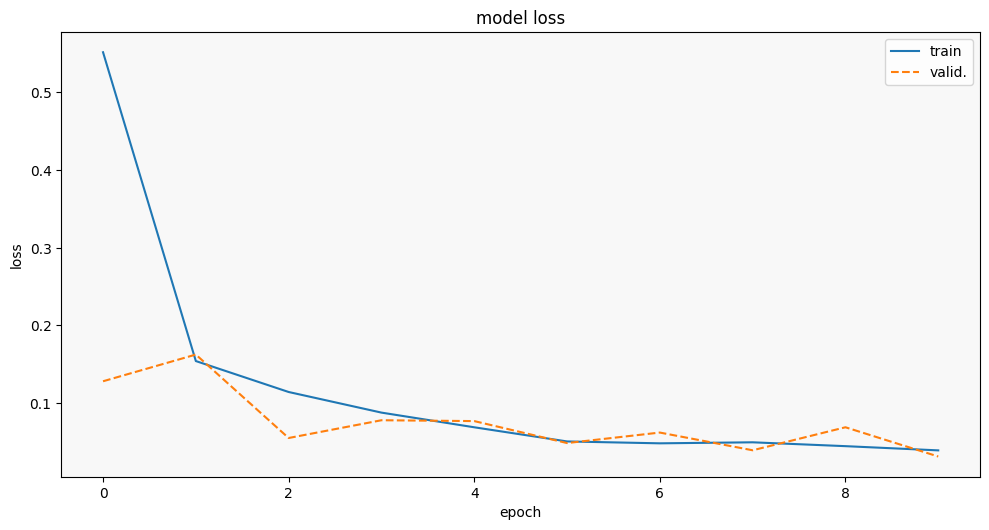

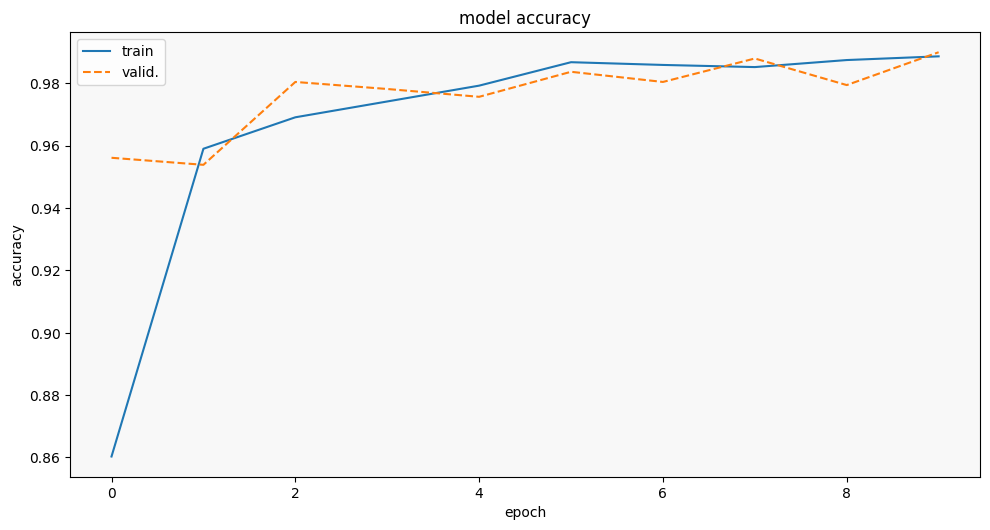

In [11]:
from matplotlib import pyplot as plt

def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation, '--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = max(len(training)*(100-zoom_pcent)//100, len(validation)*(100-zoom_pcent)//100)
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    plt.tight_layout()

display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'],
                        'accuracy', 212)

We then save the model as a keras file, as well as the json file of the class names for future use. 

In [12]:
import json

#save model
model.save("simpsons_classifier.keras")
print("Model saved to simpsons_classifier.keras!")

#save class names
with open("class_names.json", "w") as f:
    json.dump(classes, f)
print("Class names saved to 'class_names.json!")

Model saved to simpsons_classifier.keras!
Class names saved to 'class_names.json!


To double check that the model file is functioning properly, we load the file to check for successful loading.

In [13]:
# Verify saved model loads correctly
loaded_model = keras.models.load_model("simpsons_classifier.keras")

print("=" * 50)
print("MODEL VERIFICATION")
print("=" * 50)
print(f"Model loaded successfully")


MODEL VERIFICATION
Model loaded successfully
